# Pre-Process Images

The below cell takes all the images in the data folder and processes them using MediaPipe's landmark tool. Pickle is then used to store the preprocessed data and labels together in a dictionary.


In [3]:
import os
import pickle
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt

#Import MediaPipe Hands, Drawing utilities and styles
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

#Static images are being processed
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

DATA_DIR = './data'

data = []
labels = []
for dir_ in os.listdir(DATA_DIR):
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_)):
        img_data = []

        x_normal = []
        y_normal = []


        #Read the image file and convert color space from BGR to RGB
        img = cv2.imread(os.path.join(DATA_DIR, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #Process the RGB image using the MediaPipe
        results = hands.process(img_rgb)

        #If hand landmarks exist in the single image
        if results.multi_hand_landmarks:
            
            #Loop over each landmark to preprocess
            for hand_landmarks in results.multi_hand_landmarks:
                

                #Collect X & Y Coordinates for each landmark
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y

                    x_normal.append(x)
                    y_normal.append(y)


                #Normalising each landmark coordinates on the hand
                for i in range(len(hand_landmarks.landmark)):
                    x_normalised = hand_landmarks.landmark[i].x - min(x_normal)
                    y_normalised = hand_landmarks.landmark[i].y - min(y_normal)

                    #Append normalised coordinates to img_data
                    img_data.append(x_normalised)
                    img_data.append(y_normalised)


            #Append the imgs data (X&Y Coordinates for each landmark) and its respective label
            data.append(img_data)
            labels.append(dir_)

#Pickle the data for future ease of use
f = open('data.pickle', 'wb')
pickle.dump({'data': data, 'labels': labels}, f)
f.close()


# Train Model

Our CNN model is then trained on the preprocessed dataset using 500 epochs. The accuracy of the model is printed on each epoch.




In [15]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

data_dict = pickle.load(open('./data.pickle', 'rb'))

data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

#Reshape data to fit the CNN input (21 landmarks x 2 (x, y) = 42 features)
data = data.reshape((-1, 6, 7, 1)) 

#Normalize data
data = data / 255.0

#Convert string labels into integers for CNN (e.g. '0' -> 0)
labels = np.array(labels, dtype=int)

#Split data into train and test sets with fixed random state
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,  random_state=42)

#Model initialization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(6, 7, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(labels)), activation='softmax')
])

#Compile & Train model
history = model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=500, batch_size=64, validation_split=0.1)


# Save the model
model.save('cnn.h5')



Epoch 1/500
68/68 [==============================] - 4s 6ms/step - loss: 2.3028 - accuracy: 0.0975 - val_loss: 2.3030 - val_accuracy: 0.0833
Epoch 2/500
68/68 [==============================] - 0s 4ms/step - loss: 2.3026 - accuracy: 0.1056 - val_loss: 2.3032 - val_accuracy: 0.0833
Epoch 3/500
68/68 [==============================] - 0s 3ms/step - loss: 2.3025 - accuracy: 0.1056 - val_loss: 2.3033 - val_accuracy: 0.0833
Epoch 4/500
68/68 [==============================] - 0s 3ms/step - loss: 2.3023 - accuracy: 0.1056 - val_loss: 2.3031 - val_accuracy: 0.0833
Epoch 5/500
68/68 [==============================] - 0s 3ms/step - loss: 2.3020 - accuracy: 0.1056 - val_loss: 2.3027 - val_accuracy: 0.0833
Epoch 6/500
68/68 [==============================] - 0s 3ms/step - loss: 2.3013 - accuracy: 0.1084 - val_loss: 2.3023 - val_accuracy: 0.0833
Epoch 7/500
68/68 [==============================] - 0s 3ms/step - loss: 2.3003 - accuracy: 0.1114 - val_loss: 2.3004 - val_accuracy: 0.0833
Epoch 8/500
6

# Performance Metrics

The below cell displays performance metrics such as accuracy, F1 score, precision, recall and a confusion matrix to evaluate the performance of the model on the train and test datasets. Graphs showing the accuracy and loss of the model on both datasets helps us to identify any potential under/over fitting.


38/38 [==============================] - 0s 1ms/step
Test loss: 0.00042555679101496935
Test accuracy: 100.00%


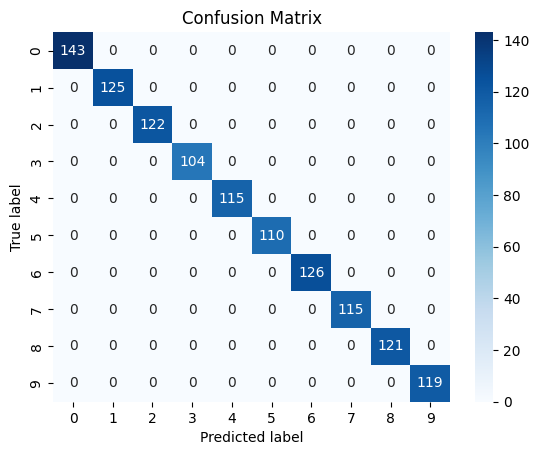

Testing Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00       125
           2       1.00      1.00      1.00       122
           3       1.00      1.00      1.00       104
           4       1.00      1.00      1.00       115
           5       1.00      1.00      1.00       110
           6       1.00      1.00      1.00       126
           7       1.00      1.00      1.00       115
           8       1.00      1.00      1.00       121
           9       1.00      1.00      1.00       119

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Precision: 100.00%
Recall: 100.00%
F1 score: 100.00%


Plotting training loss and val loss versus epoch


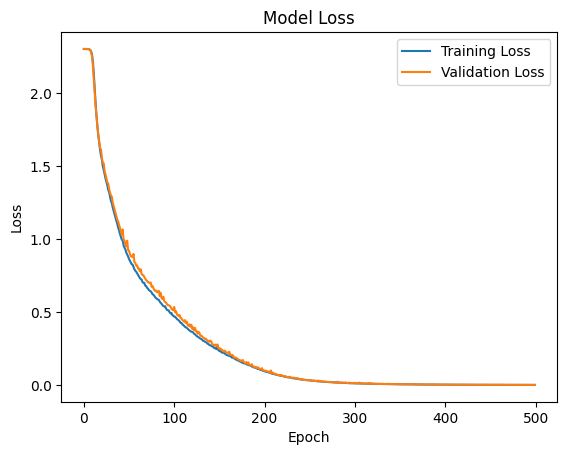

Plotting training accuracy and val accuracy versus epoch


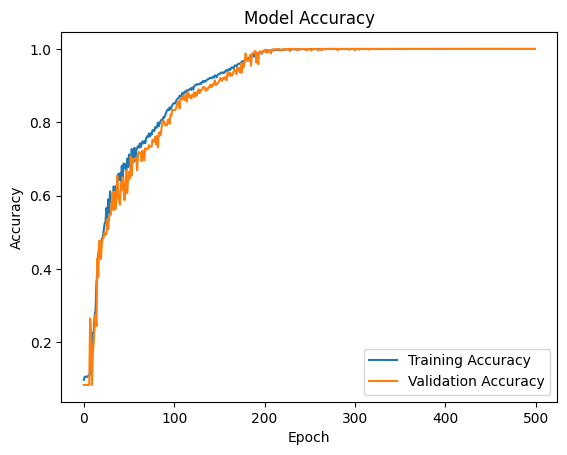

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix


model = load_model('./cnn.h5')

# Model prediction
y_pred = model.predict(x_test)
y_pred_int = y_pred.argmax(axis=-1)



#TESTING

#Model test & accuracy loss
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print('Test accuracy: {:.2f}%'.format(score[1] * 100))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_int)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


#Classification report
report = classification_report(y_test, y_pred_int)
print("Testing Classification report:")
print(report)


#Summaries of classification report
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, y_pred_int, average='macro')
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1score * 100))

print("\n")

#TRAINING

# Plot training and validation loss over time
print("Plotting training loss and val loss versus epoch")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation accuracy over time
print("Plotting training accuracy and val accuracy versus epoch")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Visualise the Dataset

Here, first image from each class of the dataset is taken and the landmarks are displayed on that image. This shows how MediaPipe landmarks the images in the dataset.


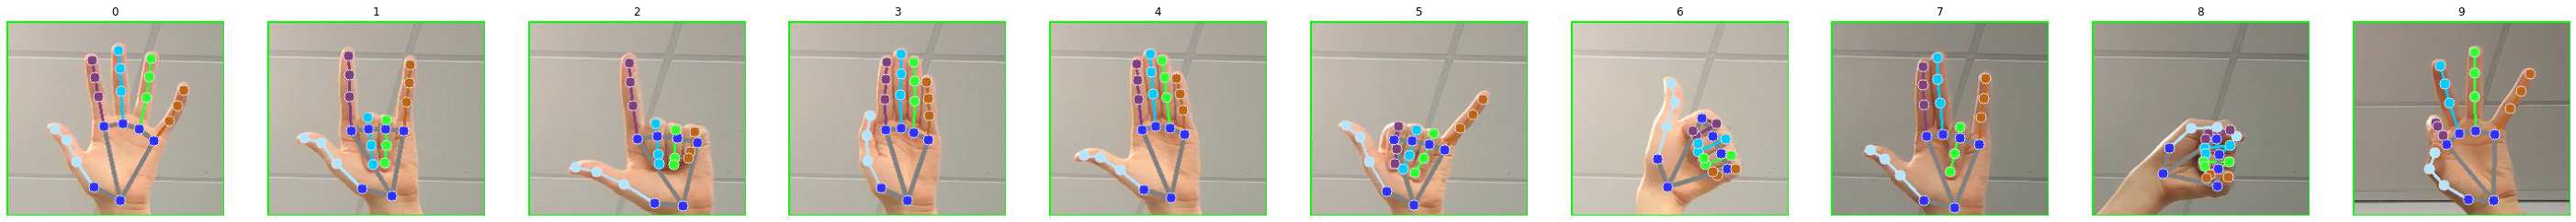

In [1]:
import os
import glob
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

#Import MediaPipe Hands, Drawing Utilities, and Drawing Styles
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

#Function to get one image from each folder in a directory
def get_one_image_from_each_folder(directory):
    images = []
    for root, dirs, files in os.walk(directory):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            image_files = glob.glob(folder_path + '/*.*')
            if image_files:
                images.append(image_files[0])
    return images

#Function to process an image and draw detected hand landmarks
def process_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    img_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

    return img_rgb

# Function to plot images with detected hand landmarks
def plot_images(image_paths):
    num_images = len(image_paths)
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 5, 5))
    for i, image_path in enumerate(image_paths):
        img = process_image(image_path)
        axs[i].imshow(img)
        axs[i].set_title(os.path.basename(os.path.dirname(image_path)))
        axs[i].axis('off')
    plt.show()


directory = './data'
image_paths = get_one_image_from_each_folder(directory)
plot_images(image_paths)


# Real Time Detection

Real time detection is performed by the below cell by detecting the hand in the ROI in real time using opencv, landmarking that hand using MediaPipe, and applying the trained CNN model on the landmarked hand to classify the sign being made.

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from keras.models import load_model
import random

model = load_model('./cnn.h5') #Loading in the model

cap = cv2.VideoCapture(0)

mpHands = mp.solutions.hands
mpDrawing = mp.solutions.drawing_utils
mpDrawingStyles = mp.solutions.drawing_styles

hands = mpHands.Hands(static_image_mode=True, min_detection_confidence=0.3)

labelNames = { #Stores the names of the classes, used to display these to the user
    0: "Hello",
    1: "I Love You",
    2: "Yes",
    3: "Stop",
    4: "Calm",
    5: "Why",
    6: "Fine",
    7: "I Hate You",
    8: "Sorry",
    9: "Money"
}

words = list(labelNames.values()) #Gets a list of the words, used for the score element

top, right, bottom, left = 10, 350, 225, 590 #Placement of the ROI

score = 0 #Initialise score to 0 on start up
currentWord = str(random.choice(words)) #Select random word for user to sign

while True:
    img_data = []
    x_normal = []
    y_normal = []

    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)  #Changes to selfie view

    H, W, _ = frame.shape

    frameRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    #Defines ROI
    roi = frameRGB[top:bottom, right:left]

    if roi.size > 0:
        #Process contents of ROI with mediapipe
        results = hands.process(roi)

        
        try: #To prevent crashing when two hands enter the frame
            cv2.putText(frame, "Please Sign: "+currentWord, (10, H-30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) #Word user must sign
            cv2.putText(frame, "Score: "+str(score), (W-350, H-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2) #Score tracking how many correct words

        
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:

                    #Collect X & Y Coordinates for each landmark
                    for i in range(21):
                        x = hand_landmarks.landmark[i].x
                        y = hand_landmarks.landmark[i].y

                        x_normal.append(x)
                        y_normal.append(y)

                    #Normalising each landmark coordinates on the hand
                    for i in range(21):
                        x_normalised = hand_landmarks.landmark[i].x - min(x_normal)
                        y_normalised = hand_landmarks.landmark[i].y - min(y_normal)

                        #Append normalised coordinates to img_data
                        img_data.append(x_normalised)
                        img_data.append(y_normalised)


                    #Reshape data to fit CNN input
                    inputData = np.array(img_data).reshape(1, 6, 7, 1)

                    inputData = inputData / 255.0 #Normalises the input data

                    prediction = model.predict(inputData) #Use model to return prediction from current input
                    predictedCharacter = np.argmax(prediction[0])
            
                    if predictedCharacter is not None:
                        #Displays the current prediction
                        cv2.putText(frame, f"Predicted Word: {labelNames[predictedCharacter]}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
                        if labelNames[predictedCharacter] == currentWord: #If the prediction is the same as the current word to sign
                            newWord = str(random.choice(words)) #Swap word to sign with a different word at random
                            while newWord == currentWord: #Prevents repeat of the same word
                                newWord = str(random.choice(words))
                            currentWord = newWord
                            score += 1 #Add 1 to score
        except: #When two hands are detected
            cv2.putText(frame, "TWO HANDS DETECTED!", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2) #Warning message


    #Draws ROI
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)

    cv2.imshow('frame', frame)
    cv2.waitKey(1)

    keypress = cv2.waitKey(1) & 0xFF
    if keypress == ord("q"): #Press q to quit
        break

cap.release()
cv2.destroyAllWindows()



1/1 [==============================] - 0s 39ms/step
